In [2]:
import os
import json
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text
from tqdm import tqdm_notebook as tqdm
import utils
import models
import imp
import copy
from collections import OrderedDict

In [3]:
tf.compat.v1.disable_eager_execution()

# Plan

Models:
 - Regexp
 - USE (https://arxiv.org/pdf/1803.11175.pdf) (Small / Large)
 - ConveRT (https://arxiv.org/pdf/2003.04807.pdf, https://arxiv.org/pdf/1911.03688.pdf)
 - USE+ConveRT (https://arxiv.org/pdf/2003.04807.pdf)
 - Conversational BERT (?)

Setups:
 - Few-shot setup (10-30 training examples per intent)
 - Full dataset
 
Modes:
 - **Multilabel** vs **Multiclass**
 - **No training (similiarity-based)** vs **MLP**
 
Datasets:
 - Alexa Prize Intent Dataset
 - SNIPS Dataset (NLU Benchmark 2017)

In [4]:
# assert tf.__version__ == "1.14.0", (
#     f"found tf version {tf.__version__}, but need 1.14.0")

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
assert len(tf.config.experimental_list_devices()),  (
    "GPU not available. please use a GPU runtime")

In [5]:
use_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
use_large_url = "https://tfhub.dev/google/universal-sentence-encoder-large/2"
convert_url = "http://models.poly-ai.com/convert/v1/model.tar.gz"

---

# Creating datasets

In [8]:
SEED = 42
FEW_SHOT_NUM = [5, 20, 50, 100]
DATASET_NAMES = ['alexa_prize', 'snips']

In [6]:
np.random.seed(SEED)

In [21]:
# For each dataset we create train dataset in different settings, and a test dataset
dataset_form = {
    "train":{
        "full": None
    },
    "valid": None,
    "test": None
}

for n in FEW_SHOT_NUM:
    dataset_form['train']['few_shot_'+str(n)] = None
dataset = {}
for dataset_name in DATASET_NAMES:
    dataset[dataset_name] = copy.deepcopy(dataset_form)
dataset

{'alexa_prize': {'train': {'full': None,
   'few_shot_5': None,
   'few_shot_20': None,
   'few_shot_50': None,
   'few_shot_100': None},
  'valid': None,
  'test': None},
 'snips': {'train': {'full': None,
   'few_shot_5': None,
   'few_shot_20': None,
   'few_shot_50': None,
   'few_shot_100': None},
  'valid': None,
  'test': None}}

## Alexa Prize

In [9]:
data = json.load(open("data/alexaprize/intent_phrases.json"))

FileNotFoundError: [Errno 2] No such file or directory: 'data/alexaprize/intent_phrases.json'

In [9]:
generated_data = dict()
for intent in data['intent_phrases']:
    generated_data[intent] = utils.generate_phrases(data['intent_phrases'][intent]['phrases'])

100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


In [10]:
generated_data

{'topic_switching': ["that's enough talking  about movies",
  'enough about music',
  "that's enough about this topic",
  'enough talking  about me',
  "that's enough talking  about the weather",
  "that's enough talking  about this thing",
  'enough about you',
  'enough about movies',
  "that's enough about you",
  "that's enough about the weather",
  "that's enough talking  about music",
  'enough talking  about politics',
  "that's enough about music",
  "that's enough talking  about me",
  "that's enough talking  about this",
  'enough about it',
  "that's enough about it",
  "that's enough about that",
  "that's enough about movies",
  "that's enough about this thing",
  "that's enough about this",
  'enough talking  about the weather',
  'enough talking  about this thing',
  'enough about politics',
  'enough talking  about music',
  "that's enough talking  about this topic",
  'enough talking  about movies',
  'enough about this thing',
  'enough talking  about this',
  'enough

In [11]:
generated_data['random'] = utils.generate_phrases(data['random_phrases']['phrases'])

100%|██████████| 855/855 [10:22<00:00,  1.18it/s]


In [12]:
generated_data

{'topic_switching': ["that's enough talking  about movies",
  'enough about music',
  "that's enough about this topic",
  'enough talking  about me',
  "that's enough talking  about the weather",
  "that's enough talking  about this thing",
  'enough about you',
  'enough about movies',
  "that's enough about you",
  "that's enough about the weather",
  "that's enough talking  about music",
  'enough talking  about politics',
  "that's enough about music",
  "that's enough talking  about me",
  "that's enough talking  about this",
  'enough about it',
  "that's enough about it",
  "that's enough about that",
  "that's enough about movies",
  "that's enough about this thing",
  "that's enough about this",
  'enough talking  about the weather',
  'enough talking  about this thing',
  'enough about politics',
  'enough talking  about music',
  "that's enough talking  about this topic",
  'enough talking  about movies',
  'enough about this thing',
  'enough talking  about this',
  'enough

In [22]:
train, test = utils.train_test_split(generated_data, train_size=0.8)
test, valid = utils.train_test_split(test, train_size=0.5)

dataset["alexa_prize"]['test'] = test
dataset["alexa_prize"]['valid'] = valid
dataset["alexa_prize"]['train']['full'] = train

for n in FEW_SHOT_NUM:
    dataset["alexa_prize"]['train']['few_shot_'+str(n)] = utils.train_test_split(train, train_num=n)[0]

In [23]:
# Let's print the stats of datasets (number of samples per intent)
print("Train data:\n")
utils.print_dataset_stat(train)
print('\n'+"-"*20+'\n')
print("Test data:\n")
utils.print_dataset_stat(test)
print('\n'+"-"*20+'\n')
print("Validate data:\n")
utils.print_dataset_stat(valid)
print('\n'+"-"*20+'\n')
print("Train few shot data:\n")
utils.print_dataset_stat(dataset["alexa_prize"]['train']['few_shot_5'])

Train data:

topic_switching:1656
lets_chat_about:8494
exit:735
tell_me_a_story:577
repeat:167
yes:112
no:68
dont_understand:260
stupid:1580
cant_do:24788
tell_me_more:276
weather_forecast_intent:6965
what_is_your_name:31
where_are_you_from:118
what_can_you_do:18
choose_topic:8
who_made_you:56
what_is_your_job:20
opinion_request:56759
doing_well:67
what_time:7
random:87540

--------------------

Test data:

topic_switching:455
lets_chat_about:2410
exit:207
tell_me_a_story:156
repeat:46
yes:31
no:17
dont_understand:72
stupid:433
cant_do:6939
tell_me_more:74
weather_forecast_intent:1949
what_is_your_name:9
where_are_you_from:32
what_can_you_do:6
choose_topic:1
who_made_you:17
what_is_your_job:5
opinion_request:15919
doing_well:19
what_time:1
random:24576

--------------------

Validate data:

topic_switching:559
lets_chat_about:2914
exit:253
tell_me_a_story:192
repeat:54
yes:37
no:20
dont_understand:84
stupid:524
cant_do:8389
tell_me_more:84
weather_forecast_intent:2369
what_is_your_name

---

## SNIPS

In [15]:
!cat data/nlu-benchmark/2017-06-custom-intent-engines/README.md

# Natural Language Understanding benchmark

This file contains the results of the benchmark we ran on June 1st 2017 to compare natural language understanding services offering custom solutions (Wit, Luis, Api, and Snips) for seven intents. This benchmark and its results are described in [this paper](https://arxiv.org/abs/1805.10190) and [this blog post](https://medium.com/@alicecoucke/benchmarking-natural-language-understanding-systems-google-facebook-microsoft-and-snips-2b8ddcf9fb19).

**Any publication based on these datasets must include a full citation to the following paper in which the results were published by Snips:** 

["Snips Voice Platform: an embedded Spoken Language Understanding system 
for private-by-design voice interfaces"](https://arxiv.org/abs/1805.10190)


## Method
We focused on seven `intents`:
* SearchCreativeWork (e.g. *Find me the I, Robot television show*),
* GetWeather (e.g. *Is it windy in Boston, MA right now?*),
* BookRestaurant (e.g. *I want to book a hig

In [13]:
# prepare SNIPS intent data for intent classification task
def prepare_intent_data(data):
    new_data = []
    for example in tqdm(data):
        new_data.append("".join([t['text'] for t in example['data']]))
    return new_data

In [14]:
directory = 'data/nlu-benchmark/2017-06-custom-intent-engines/'
train = {}
test = {}
valid = {}
for item in os.listdir(directory):
    if os.path.isdir(directory+item):
        train_data = json.load(open(directory+item+'/train_'+item+'_full.json', encoding='cp1251'))
        test_data = json.load(open(directory+item+'/validate_'+item+'.json', encoding='cp1251'))
        train[item] = prepare_intent_data(train_data[item])
        test[item] = prepare_intent_data(test_data[item])
valid, train = utils.train_test_split(train, train_num=100)
dataset["snips"]['train']['full'] = train
dataset["snips"]['test'] = test
dataset["snips"]['valid'] = valid
for n in FEW_SHOT_NUM:
    dataset["snips"]['train']['few_shot_'+str(n)] = copy.deepcopy(utils.train_test_split(train_, train_num=n)[0])

NameError: name 'FEW_SHOT_NUM' is not defined

In [17]:
#snips train data
# Let's print the stats of datasets (number of samples per intent)
print("Train data:\n")
utils.print_dataset_stat(train)
print('\n'+"-"*20+'\n')
print("Test data:\n")
utils.print_dataset_stat(test)
print('\n'+"-"*20+'\n')
print("Validate data:\n")
utils.print_dataset_stat(valid)
print('\n'+"-"*20+'\n')
print("Train few shot data:\n")
utils.print_dataset_stat(dataset["snips"]['train']['few_shot_50'])

Train few shot data:

SearchScreeningEvent:50
RateBook:50
AddToPlaylist:50
BookRestaurant:50
SearchCreativeWork:50
GetWeather:50
PlayMusic:50


In [16]:
json.dump(dataset, open("data/full_dataset.json", 'w'))

---

In [5]:
dataset = json.load(open("data/full_dataset.json"))

----

In [7]:
encoders = {
    'use':hub.Module(use_url),
    'use_large':hub.Module(use_large_url),
    'convert':hub.Module(convert_url)
}
encoders['use+convert'] = utils.concatenate_encoders(encoders['use'], encoders['convert'])

In [8]:
results = {'alexa_prize':{}, 'snips':{}}
# results = json.load(open('data/results.json'))

# Model testing: Alexa prize

In [9]:
data = dataset['alexa_prize']
for encoder_name, encoder in encoders.items():
    results['alexa_prize'][encoder_name] = utils.eval_all_models(encoder, data, num_intents=22)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: sml


100%|██████████| 5/5 [08:59<00:00, 110.00s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: smc


100%|██████████| 5/5 [04:00<00:00, 49.31s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mml
Instructions for updating:
Please use `model.predict()` instead.


Instructions for updating:
Please use `model.predict()` instead.
100%|██████████| 5/5 [08:20<00:00, 104.84s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mmc


100%|██████████| 5/5 [06:14<00:00, 79.59s/it] 


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: sml


100%|██████████| 5/5 [1:19:18<00:00, 957.44s/it] 


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: smc


100%|██████████| 5/5 [40:02<00:00, 484.54s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mml


100%|██████████| 5/5 [14:44<00:00, 185.84s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mmc


100%|██████████| 5/5 [11:20<00:00, 143.59s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: sml


100%|██████████| 5/5 [52:04<00:00, 631.99s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: smc


100%|██████████| 5/5 [27:14<00:00, 331.49s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mml


100%|██████████| 5/5 [14:23<00:00, 176.00s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mmc


100%|██████████| 5/5 [11:03<00:00, 140.24s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: sml


100%|██████████| 5/5 [48:12<00:00, 588.50s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: smc


100%|██████████| 5/5 [25:42<00:00, 314.29s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mml


100%|██████████| 5/5 [15:25<00:00, 192.78s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mmc


100%|██████████| 5/5 [13:07<00:00, 166.95s/it]


---

# Model testing: SNIPS

In [10]:
data = dataset['snips']
for encoder_name, encoder in encoders.items():
    results['snips'][encoder_name] = utils.eval_all_models(encoder, data, num_intents=7)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: sml


100%|██████████| 5/5 [02:33<00:00, 30.73s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: smc


100%|██████████| 5/5 [02:22<00:00, 28.44s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mml


100%|██████████| 5/5 [04:01<00:00, 50.14s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mmc


100%|██████████| 5/5 [04:08<00:00, 51.38s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: sml


100%|██████████| 5/5 [03:30<00:00, 42.44s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: smc


100%|██████████| 5/5 [03:04<00:00, 37.10s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mml


100%|██████████| 5/5 [04:55<00:00, 61.54s/it] 


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mmc


100%|██████████| 5/5 [04:59<00:00, 62.03s/it] 


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: sml


100%|██████████| 5/5 [03:42<00:00, 44.68s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: smc


100%|██████████| 5/5 [03:16<00:00, 39.49s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mml


100%|██████████| 5/5 [05:22<00:00, 67.01s/it] 


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mmc


100%|██████████| 5/5 [05:25<00:00, 67.43s/it] 


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: sml


100%|██████████| 5/5 [04:01<00:00, 48.59s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: smc


100%|██████████| 5/5 [03:37<00:00, 43.72s/it]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mml


100%|██████████| 5/5 [06:15<00:00, 78.29s/it] 


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
  0%|          | 0/5 [00:00<?, ?it/s]

Training: mmc


100%|██████████| 5/5 [06:30<00:00, 81.01s/it] 


----

In [11]:
results['alexa_prize']

{'use': {'sml': {'full': 0.9551279649267433,
   'few_shot_5': 0.5090680855847416,
   'few_shot_20': 0.8216547382620751,
   'few_shot_50': 0.7353767752089032,
   'few_shot_100': 0.8633229662382433},
  'smc': {'full': 0.9973582643234533,
   'few_shot_5': 0.6071870198973283,
   'few_shot_20': 0.8780117660284034,
   'few_shot_50': 0.9204294225652939,
   'few_shot_100': 0.9491512721549819},
  'mml': {'full': 0.9851987859257316,
   'few_shot_5': 0.5458275564881777,
   'few_shot_20': 0.5849664630719077,
   'few_shot_50': 0.7277513396035523,
   'few_shot_100': 0.8092704312961367},
  'mmc': {'full': 0.995409750065575,
   'few_shot_5': 0.7543185820811631,
   'few_shot_20': 0.9024244013939371,
   'few_shot_50': 0.937872372316109,
   'few_shot_100': 0.9609173005583242}},
 'use_large': {'sml': {'full': 0.8491587664405891,
   'few_shot_5': 0.3470228950425301,
   'few_shot_20': 0.6714879904073144,
   'few_shot_50': 0.6822422902536815,
   'few_shot_100': 0.703170082811856},
  'smc': {'full': 0.9974706

In [12]:
results['snips']

{'use': {'sml': {'full': 0.48142857142857143,
   'few_shot_5': 0.36142857142857143,
   'few_shot_20': 0.38857142857142857,
   'few_shot_50': 0.5628571428571428,
   'few_shot_100': 0.4785714285714286},
  'smc': {'full': 0.9428571428571428,
   'few_shot_5': 0.8285714285714286,
   'few_shot_20': 0.8371428571428572,
   'few_shot_50': 0.9014285714285715,
   'few_shot_100': 0.8857142857142857},
  'mml': {'full': 0.91,
   'few_shot_5': 0.6414285714285715,
   'few_shot_20': 0.6785714285714286,
   'few_shot_50': 0.6814285714285714,
   'few_shot_100': 0.7828571428571428},
  'mmc': {'full': 0.9671428571428572,
   'few_shot_5': 0.8514285714285714,
   'few_shot_20': 0.8857142857142857,
   'few_shot_50': 0.9185714285714286,
   'few_shot_100': 0.9257142857142857}},
 'use_large': {'sml': {'full': 0.5042857142857143,
   'few_shot_5': 0.6371428571428571,
   'few_shot_20': 0.5971428571428572,
   'few_shot_50': 0.5771428571428572,
   'few_shot_100': 0.6085714285714285},
  'smc': {'full': 0.965714285714285

In [13]:
json.dump(results, open("data/results.json", 'w'))

# Final results

In [ ]:
# Tables
# Each for each dataset and each setting


# Tables format 
#(MC - multiclass; ML - multilabel)
#
# Models | Similarity MC | Similarity ML | MLP MC | MLP ML
# USE_small | ...
# USE_large | ...
# ...
#
#
#

# Few-shot setting: 2 tables
# Full setting: 2 tables 
# All-in-all: 4 tables

# Plots

In [114]:
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline

In [272]:
color_map = {
    'use':'red',
    'use_large':'green',
    'convert':'purple',
    'use+convert':'blue',
    'mmc':'red',
    'mml':'green',
    'sml':'purple',
    'smc':'blue'
}

model_names = {
    'mmc':'Multiclass MLP',
    'mml':'Multilabel MLP',
    'sml':'Multilabel similarity',
    'smc':'Multiclass similarity',
    'use':'Universal Sentence Encoder',
    'use_large':'Universal Sentence Encoder (Large)',
    'convert':'ConveRT',
    'use+convert':'USE and ConveRT concatenation'
}

def one_plot(data, model_name='mmc', encoder_name='use', add_full=True):
    figure = plt.figure(figsize=(10, 6))
    x, y = zip(*[(key, value) for key, value in data[encoder_name][model_name].items() if key !='full'])
    x = [int(s.split('_')[-1]) for s in x]
    plt.plot(x, y, color=color_map[encoder_name], label=encoder_name, figure=figure, marker='s', alpha=0.9)
    if add_full:
        y = data[encoder_name][model_name]['full']
        plt.hlines(y,xmin=-10, xmax=110, color='black', linestyle='dashed', figure=figure)
    plt.title(model_names[model_name])
    plt.legend()

def plot_one_model(data, fig, ax, model_name='sml', setting='few_shot', add_legend=False):
    for encoder_name in data:
        x, y = [], []
        if setting=='few_shot':
            x, y = zip(*[(key, value) for key, value in data[encoder_name][model_name].items() if key !='full'])
            x = [int(s.split('_')[-1]) for s in x]
            ax.plot(x, y, color=color_map[encoder_name], label=model_names[encoder_name], figure=fig, marker='s', alpha=0.9)
            
        elif setting=='full':
            pass
        ax.title.set_text(model_names[model_name])
        if add_legend:
            ax.legend(loc='lower right', fontsize='x-large')
#         ax.set_xlabel('Number of samples in train dataset')
#         ax.set_ylabel('Accuracy')
        ax.grid(color='black', linestyle='-.')
    return ax  
    
def plot_mutliple_models(data, fig, ax, encoder_name='use', add_legend=False):
    for model_name in data[encoder_name]:
        x, y = [], []
        x, y = zip(*[(key, value) for key, value in data[encoder_name][model_name].items() if key !='full'])
        x = [int(s.split('_')[-1]) for s in x]
        ax.plot(x, y, color=color_map[model_name], label=model_names[model_name], figure=fig, marker='s', alpha=0.9)
        ax.title.set_text(model_names[encoder_name])
        if add_legend:
            ax.legend(loc='lower right', fontsize='x-large')
#         ax.set_xlabel('Number of samples in train dataset')
#         ax.set_ylabel('Accuracy')
        ax.grid(color='black', linestyle='-.')
    return ax

Text(0.5, 0, 'Number of samples in train dataset')

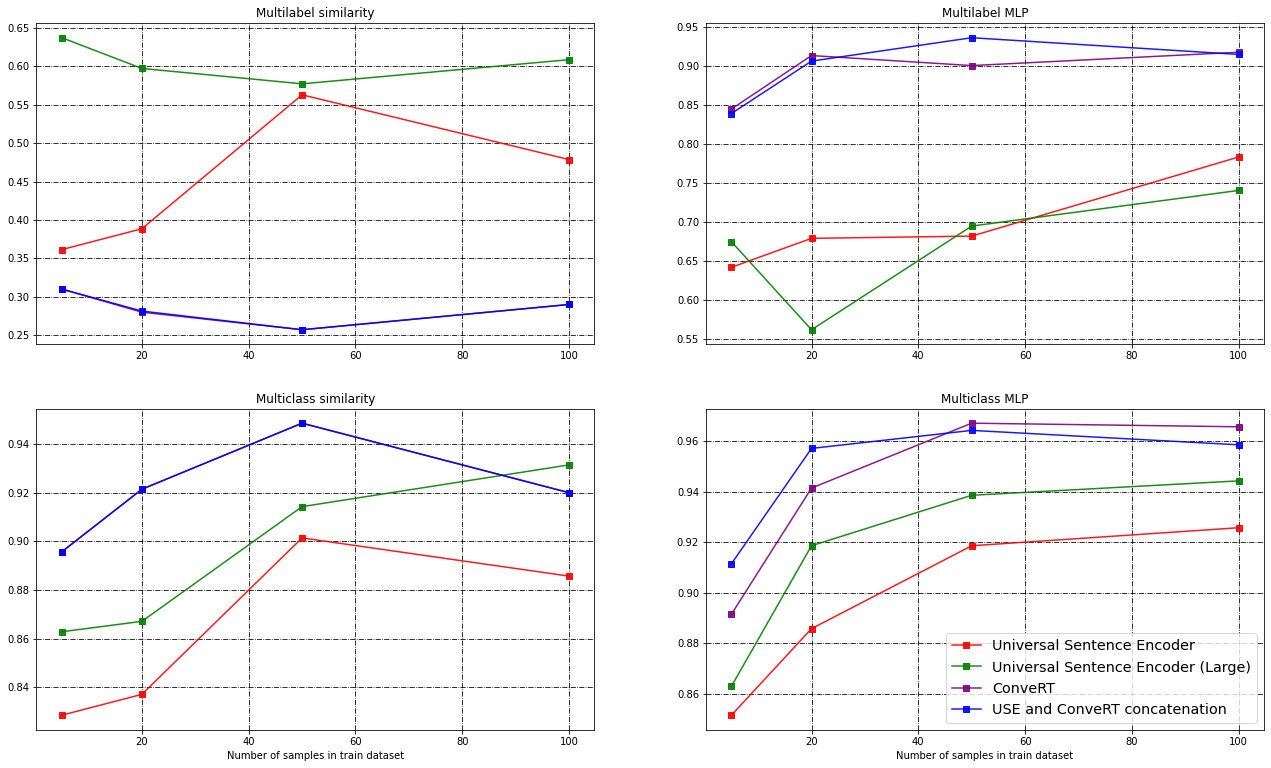

In [275]:
data = results['snips']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,  13))
plot_one_model(data, fig, ax[0, 0], model_name='sml')
plot_one_model(data, fig, ax[1, 0], model_name='smc')
plot_one_model(data, fig, ax[0, 1], model_name='mml')
plot_one_model(data, fig, ax[1, 1], model_name='mmc', add_legend=True)

# ax[0, 1].set_ylabel('Accuracy')
# ax[0, 0].set_ylabel('Accuracy')

ax[1, 0].set_xlabel('Number of samples in train dataset')
ax[1, 1].set_xlabel('Number of samples in train dataset')

Text(0.5, 0, 'Number of samples in train dataset')

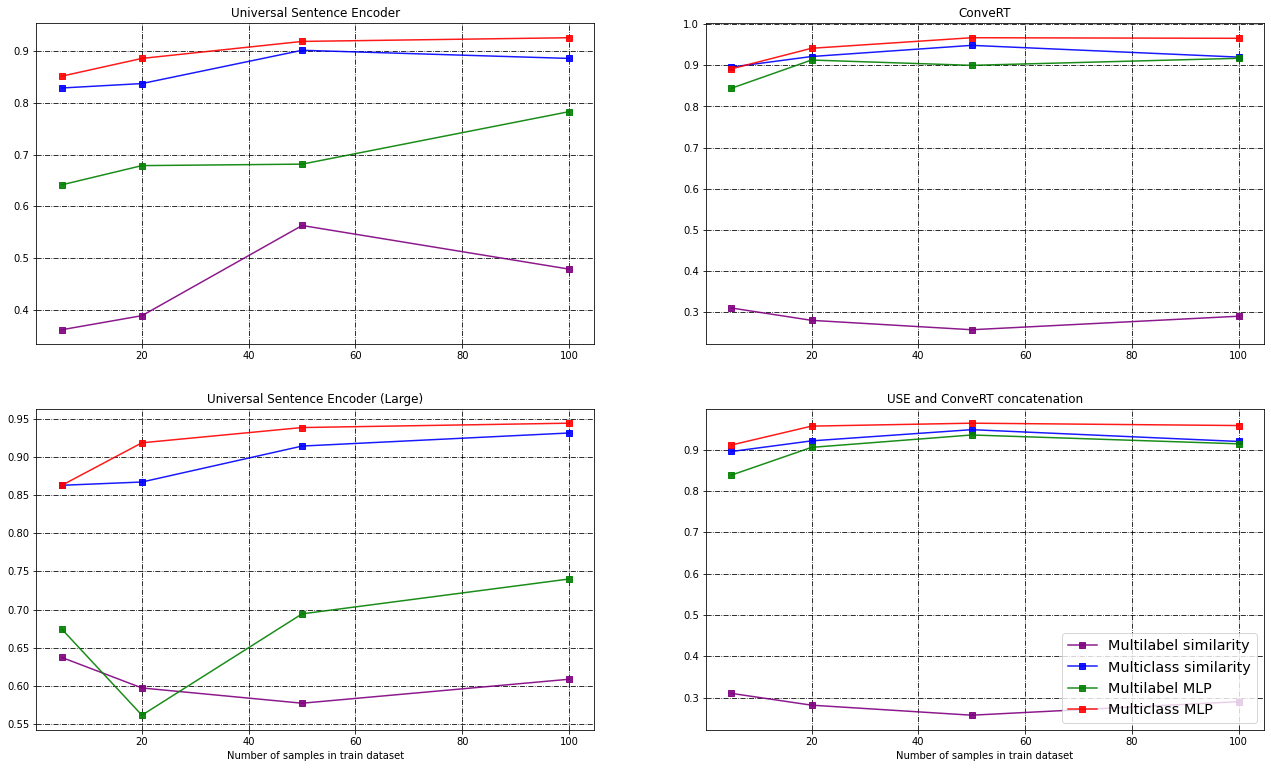

In [277]:
data = results['snips']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,  13))
plot_mutliple_models(data, fig, ax[0, 0], encoder_name='use')
plot_mutliple_models(data, fig, ax[1, 0], encoder_name='use_large')
plot_mutliple_models(data, fig, ax[0, 1], encoder_name='convert')
plot_mutliple_models(data, fig, ax[1, 1], encoder_name='use+convert', add_legend=True)

# ax[0, 1].set_ylabel('Accuracy')
# ax[0, 0].set_ylabel('Accuracy')

ax[1, 0].set_xlabel('Number of samples in train dataset')
ax[1, 1].set_xlabel('Number of samples in train dataset')

In [257]:
results['alexa_prize']

{'use': {'sml': {'full': 0.9551279649267433,
   'few_shot_5': 0.5090680855847416,
   'few_shot_20': 0.8216547382620751,
   'few_shot_50': 0.7353767752089032,
   'few_shot_100': 0.8633229662382433},
  'smc': {'full': 0.9973582643234533,
   'few_shot_5': 0.6071870198973283,
   'few_shot_20': 0.8780117660284034,
   'few_shot_50': 0.9204294225652939,
   'few_shot_100': 0.9491512721549819},
  'mml': {'full': 0.9851987859257316,
   'few_shot_5': 0.5458275564881777,
   'few_shot_20': 0.5849664630719077,
   'few_shot_50': 0.7277513396035523,
   'few_shot_100': 0.8092704312961367},
  'mmc': {'full': 0.995409750065575,
   'few_shot_5': 0.7543185820811631,
   'few_shot_20': 0.9024244013939371,
   'few_shot_50': 0.937872372316109,
   'few_shot_100': 0.9609173005583242}},
 'use_large': {'sml': {'full': 0.8491587664405891,
   'few_shot_5': 0.3470228950425301,
   'few_shot_20': 0.6714879904073144,
   'few_shot_50': 0.6822422902536815,
   'few_shot_100': 0.703170082811856},
  'smc': {'full': 0.9974706

In [131]:
def make_table(data):
    table_results = {}
    for encoder_name in data:
        table_results[encoder_name] = {
            key:round(value['full'], 3) for key, value in data[encoder_name].items()
        }
    return pd.DataFrame.from_dict(table_results)

In [154]:
make_table(results['snips'])

,use,use_large,convert,use+convert
sml,0.481,0.504,0.247,0.247
smc,0.943,0.966,0.971,0.971
mml,0.910,0.931,0.957,0.964
mmc,0.967,0.979,0.986,0.989


План на утро

1. Сделать таблички с результатами для full (2 таблицы), можно одну сплошную с 2  multicolumn наверху
2. Результаты - лучший энкодер, как и подтверждено в работе - use+convert / convert; Лучшая модель - Multiclass MLP;
3. Сказать, что similarity достигает сравнимых результатов с обучением модели - выводы: хорошее качество embedding от encoder, поистине few-shot learners
4. Сделать графики similarity vs MLP; mutliclass vs multilabel;

In [143]:
utils.print_dataset_stat(dataset['snips']['valid'])

SearchScreeningEvent:100
RateBook:100
AddToPlaylist:100
BookRestaurant:100
SearchCreativeWork:100
GetWeather:100
PlayMusic:100
